In [1]:
import os 
import numpy as np
import torch
from utils1 import * 
import h5py
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
train_file_path = '/home/rishabh.mondal/final_train.hdf5'
test_file_path = '/home/rishabh.mondal/final_val.hdf5'

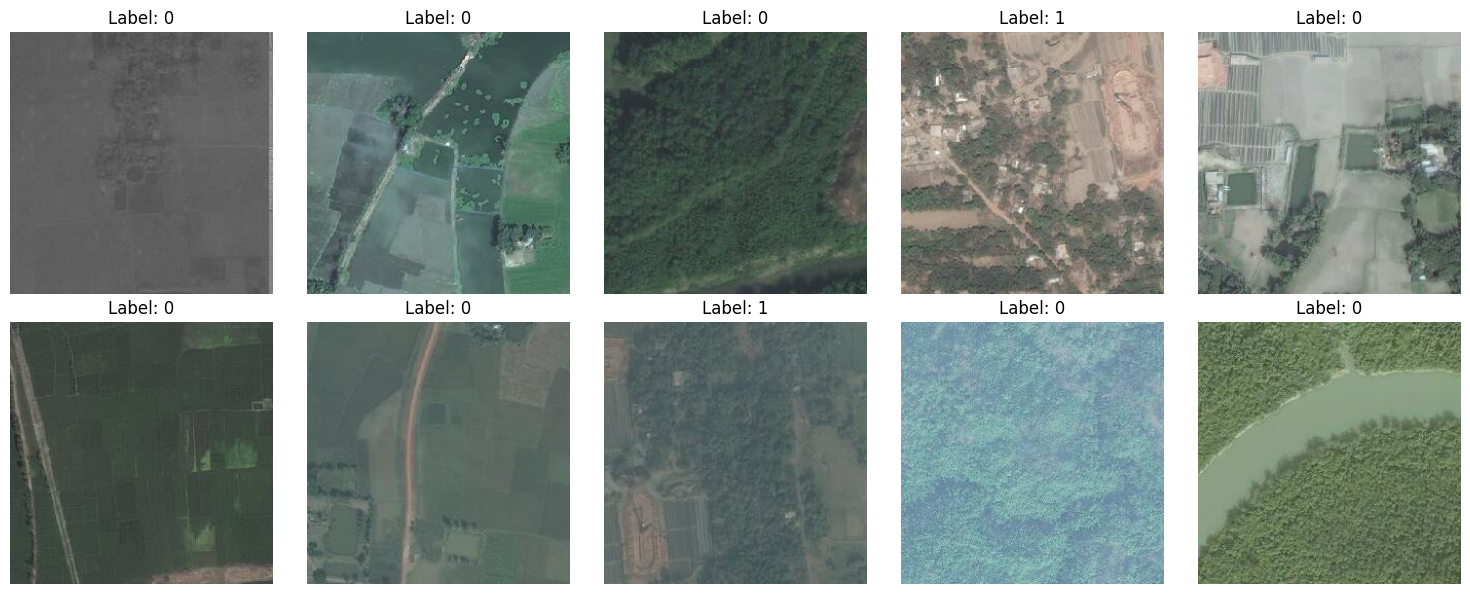

In [3]:
show_random_images_with_labels(train_file_path, 10)

In [4]:
x_train, y_train = load_hdf5_data(train_file_path)
x_test, y_test = load_hdf5_data(test_file_path)

Images shape:  (2186, 256, 256, 3)
Labels shape:  (2186,)
Images shape:  (618, 256, 256, 3)
Labels shape:  (618,)


In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
class_0_train_count=np.sum(y_train==0)
class_1_train_count=np.sum(y_train==1)
class_0_val_count=np.sum(y_val==0)
class_1_val_count=np.sum(y_val==1)
class_0_test_count=np.sum(y_test==0)
class_1_test_count=np.sum(y_test==1)
print("Total train count: ", len(y_train))
print("Train class train 0 count: ", class_0_train_count)
print("Train class train 1 count: ", class_1_train_count)
print("Val class val 0 count: ", class_0_val_count)
print("Val class val 1 count: ", class_1_val_count)
print("Test class test 0 count: ", class_0_test_count)
print("Test class test 1 count: ", class_1_test_count)


Total train count:  1748
Train class train 0 count:  1533
Train class train 1 count:  215
Val class val 0 count:  384
Val class val 1 count:  54
Test class test 0 count:  545
Test class test 1 count:  73


In [6]:


resized_x_train = np.zeros((x_train.shape[0], 224, 224, 3), dtype=np.uint8)
print(resized_x_train.shape)
resized_x_test = np.zeros((x_test.shape[0], 224, 224, 3), dtype=np.uint8)
resized_x_val = np.zeros((x_val.shape[0], 224, 224, 3), dtype=np.uint8)
for i in range(x_train.shape[0]):
    img = Image.fromarray(x_train[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_train[i] = np.array(img)

for i in range(x_test.shape[0]):
    img = Image.fromarray(x_test[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_test[i] = np.array(img)

for i in range(x_val.shape[0]):
    img = Image.fromarray(x_val[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_val[i] = np.array(img)    

(1748, 224, 224, 3)


/tmp/ipykernel_3087147/2002680331.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_3087147/2002680331.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_3087147/2002680331.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


In [7]:
print(resized_x_train.shape)

(1748, 224, 224, 3)


In [8]:
from torch.utils.data import DataLoader, TensorDataset


In [9]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary




In [11]:
def resnet50(larning_rate=0.0002,fine_tune=True,seed=42):
    torch.manual_seed(seed)    
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False

    num_fitrs = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(num_fitrs, 2048),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(2048, 1),
        nn.Sigmoid()
    )    
    criterion=nn.BCELoss()
    optimizer = torch.optim.Adam(resnet.parameters(), lr=larning_rate)
    return resnet, criterion, optimizer

# def resnet101(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     resnet = models.resnet101(pretrained=True)
#     for param in resnet.parameters():
#         param.requires_grad = False

#     num_fitrs = resnet.fc.in_features
#     resnet.fc = nn.Sequential(
#         nn.Linear(num_fitrs, 2048),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(2048, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(resnet.parameters(), lr=larning_rate)
#     return resnet, criterion, optimizer

# def dense_net(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     densenet = models.densenet121(pretrained=True)
#     for param in densenet.parameters():
#         param.requires_grad = False

#     num_fitrs = densenet.classifier.in_features
#     densenet.classifier = nn.Sequential(
#         nn.Linear(num_fitrs, 1024),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(1024, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(densenet.parameters(), lr=larning_rate)
#     return densenet, criterion, optimizer

# def vgg16(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     vgg = models.vgg16(pretrained=True)
#     for param in vgg.parameters():
#         param.requires_grad = False

#     num_fitrs = vgg.classifier[6].in_features
#     vgg.classifier = nn.Sequential(
#         nn.Linear(num_fitrs, 1024),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(1024, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(vgg.parameters(), lr=larning_rate)
#     return vgg, criterion, optimizer

In [12]:
#summery of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for seed in seeds:
    model, criterion, optimizer = resnet50(seed=seed)
    model = model.to(device)
    summary(model, (3, 224, 224))
    del model, criterion, optimizer


# model, criterion, optimizer = resnet50()
# model = model.to(device)

# model1, criterion1, optimizer1 = resnet101()
# model1 = model1.to(device)

# model2, criterion2, optimizer2 = dense_net()
# model2.to(device)
# model3, criterion3, optimizer3 = vgg16()
# model3.to(device)


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
seeds = [1, 2]


train_losses_per_seed = []
train_accuracies_per_seed = []


val_losses_per_seed = []
val_accuracies_per_seed = []


test_losses_per_seed = []
test_accuracies_per_seed = []

In [52]:

for seed in seeds:
    model, criterion, optimizer = resnet50(seed=seed)
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_samples = 0
        total_correct = 0
        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            output = output.squeeze(dim=1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += (output.round() == labels).sum().item()

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = (total_correct / total_samples)*100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_total_samples = 0
        val_total_correct = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.squeeze(dim=1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                val_total_samples += labels.size(0)
                val_total_correct += (outputs.round() == labels).sum().item()
                
            val_loss = val_loss / len(val_loader)
            val_acc = (val_total_correct / val_total_samples)*100
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    val_accuracies_per_seed.append(val_accuracies)
    val_losses_per_seed.append(val_losses)    
    train_losses_per_seed.append(train_losses)
    train_accuracies_per_seed.append(train_accuracies)   

    print(f'Final validation loss and accuracy for seed {seed}: {val_losses[-1]:.4f}', f'{val_accuracies[-1]:.4f}')
    print(f'Final training loss for seed {seed}: {train_losses[-1]:.4f}', f'{train_accuracies[-1]:.4f}')


    true_labels = []
    predicted_labels = []
    model.eval()  
    test_loss = 0.0
    test_total_samples = 0
    test_total_correct = 0
    with torch.no_grad():  
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = output.squeeze(dim=1)

            loss = criterion(output, labels)
            test_loss += loss.item()

            predicted = (output.round() == 1.0)  
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())        

            test_total_samples += labels.size(0)
            test_total_correct += (output.round() == labels).sum().item()


        test_accuracy = (test_total_correct / test_total_samples) * 100
    test_accuracies_per_seed.append(test_accuracy)
    print(f'Final test accuracy for seed {seed}: {test_accuracy:.4f}')

Final training loss for seed 1: 0.1459
Final training accuracy for seed 1: 94.5652
Final validation loss for seed 1: 0.2087
Final validation accuracy for seed 1: 93.6073
Final test accuracy for seed 1: 93.2039
Final training loss for seed 2: 0.1467
Final training accuracy for seed 2: 94.6224
Final validation loss for seed 2: 0.2192
Final validation accuracy for seed 2: 93.6073
Final test accuracy for seed 2: 92.8803


In [53]:
# print(train_losses)
# print(train_losses_per_seed)

[0.3873524016567639, 0.26925396599939894, 0.21517521728362357, 0.1954763654087271, 0.18042512104979583, 0.18318125046789646, 0.15450113532798632, 0.15789084136486053, 0.14778263201670988, 0.14666218849431192]
[[0.3745257875749043, 0.25356119658265797, 0.21762799844145775, 0.18374653080744402, 0.17769012626792705, 0.18481538631021976, 0.1593757217217769, 0.16145075006144388, 0.1621289649712188, 0.14594948012381792], [0.3873524016567639, 0.26925396599939894, 0.21517521728362357, 0.1954763654087271, 0.18042512104979583, 0.18318125046789646, 0.15450113532798632, 0.15789084136486053, 0.14778263201670988, 0.14666218849431192]]


In [54]:
train_losses_per_seed = np.array(train_losses_per_seed)
train_accuracies_per_seed = np.array(train_accuracies_per_seed)


mean_train_losses = np.mean(train_losses_per_seed, axis=0)
var_train_losses = np.var(train_losses_per_seed, axis=0)
mean_train_accuracies = np.mean(train_accuracies_per_seed, axis=0)
var_train_accuracies = np.var(train_accuracies_per_seed, axis=0)

In [55]:
# print(mean_train_losses)
# print(var_train_losses)

[0.38093909 0.26140758 0.21640161 0.18961145 0.17905762 0.18399832
 0.15693843 0.1596708  0.1549558  0.14630583]
[4.11305072e-05 6.15657530e-05 1.50403385e-06 3.43972549e-05
 1.87004911e-06 6.67599988e-07 5.94039813e-06 3.16823748e-06
 5.14543173e-05 1.26988305e-07]


In [56]:
print(mean_train_accuracies)
print(var_train_accuracies)

[85.15446224 89.01601831 92.0194508  92.59153318 92.90617849 93.13501144
 94.10755149 94.05034325 94.33638444 94.59382151]
[0.00736376 0.39600668 0.0008182  0.51137226 0.32727825 0.16036634
 0.08181956 0.00327278 0.11782017 0.0008182 ]


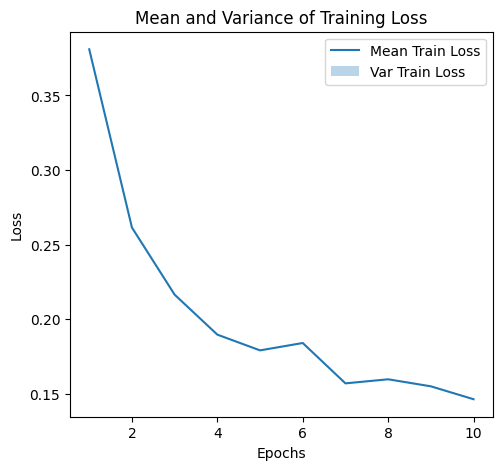

In [57]:
epochs = range(1, num_epochs + 1)
# Plot mean and variance for training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_losses,label='Mean Train Loss')
plt.fill_between(epochs, mean_train_losses - var_train_losses, mean_train_losses + var_train_losses, alpha=0.3, label='Var Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mean and Variance of Training Loss')
plt.legend();

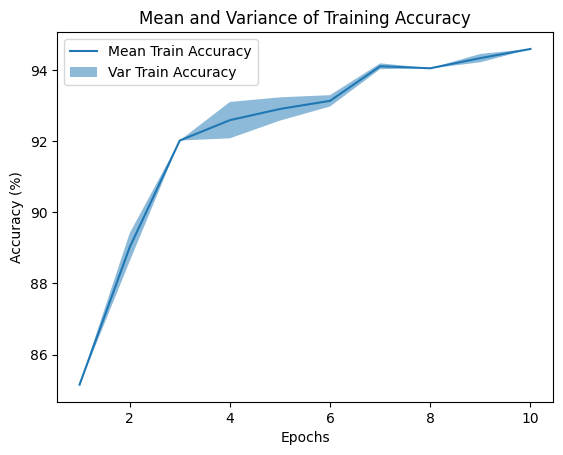

In [58]:

# Plot mean and variance for training accuracy
plt.plot(epochs, mean_train_accuracies, label='Mean Train Accuracy')
plt.fill_between(epochs, mean_train_accuracies - var_train_accuracies, mean_train_accuracies + var_train_accuracies, alpha=0.5, label='Var Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Mean and Variance of Training Accuracy')
plt.legend()


In [59]:
val_acc_per_seed = np.array(val_accuracies_per_seed)
val_losses_per_seed = np.array(val_losses_per_seed)
test_accuracies_per_seed = np.array(test_accuracies_per_seed)

In [74]:
print(test_accuracies_per_seed)
#find max values of test accuracy
max_test_accuracy = np.max(test_accuracies_per_seed)
print(max_test_accuracy)
#find the presicion and recall
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
print(precision, recall, fscore)

[93.2038835 92.8802589]
93.20388349514563
0.8536585365853658 0.4794520547945205 0.6140350877192982


In [61]:
print(val_acc_per_seed)

[[93.60730594]
 [93.60730594]]


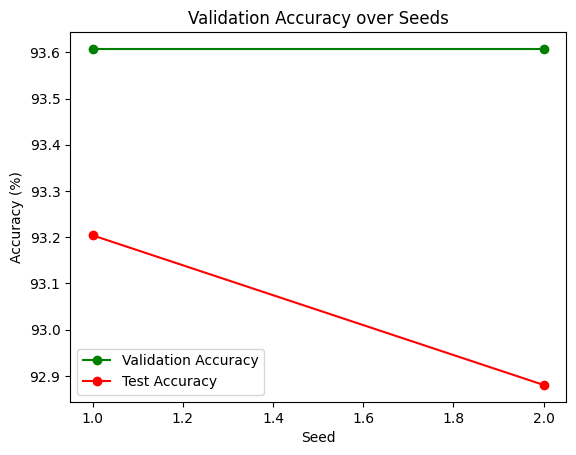

In [76]:
#plot validation  over seeds
seed_range = range(1, len(seeds) + 1)
plt.plot(seed_range, val_acc_per_seed, 'o-',label='Validation Accuracy', color='green')
plt.plot(seed_range, test_accuracies_per_seed, 'o-', label='Test Accuracy', color='red')    
plt.xlabel('Seed')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Seeds')
plt.legend();

[[539   6]
 [ 38  35]]


<Axes: >

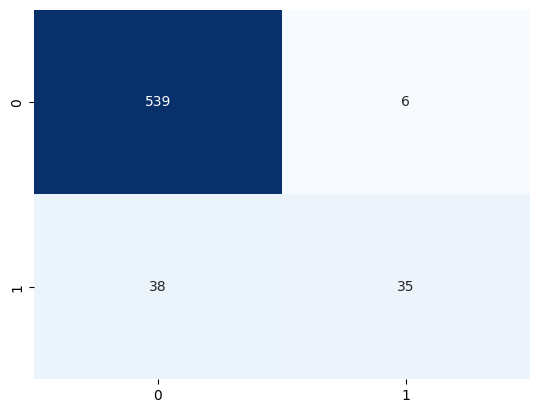

In [77]:
#plot the confution matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

In [ ]:
true_labels = []
predicted_labels = []
model.eval()  # Set the model in evaluation mode
test_loss = 0.0
test_total_samples = 0
test_total_correct = 0


with torch.no_grad():  #
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output = output.squeeze(dim=1)

        loss = criterion(output, labels)
        test_loss += loss.item()

        predicted = (output.round() == 1.0)  # Assuming binary classification
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())        

        test_total_samples += labels.size(0)
        test_total_correct += (output.round() == labels).sum().item()

# Calculate test loss and accuracy
test_loss = test_loss / len(resized_x_test)
test_accuracy = (test_total_correct / test_total_samples) * 100
results_str = f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}%'

print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}%')
with open('results_densenet', 'w') as file:
    # Write the test results to the file
    file.write(results_str)

print("Test results saved to 'results_densenet.txt'.")


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_dense.png')
plt.show()


# Densenet

In [ ]:
for key, var in locals().items():
    if isinstance(var, torch.Tensor):
       locals()[key] = var.cuda()
    if isinstance(var, torch.nn.Module):
       locals()[key] = var.cuda() 

In [ ]:

# model = densenet_model(learning_rate=0.00002)

# summary(model, input_size=(3, 224, 224))